In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [7]:
df = read_csv_replace_missing_by_polynomial('idh_renda.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.578,0.43,0.762,0.635,0.599,0.449,0.965,0.873,0.887,0.334,...,0.934,0.961,0.477,0.747,0.939,0.953,0.943,0.544,0.962,0.45
1991,0.611,0.435,0.743,0.802,0.478,0.454,0.969,0.804,0.875,0.313,...,0.94,0.954,0.507,0.662,0.954,0.949,0.943,0.521,0.96,0.515
2012,0.67,0.627,0.683,0.673,0.666,0.648,0.846,0.73,0.73,0.602,...,0.757,0.756,0.658,0.692,0.717,0.767,0.764,0.679,0.782,0.674
2013,0.67,0.629,0.683,0.691,0.667,0.656,0.848,0.734,0.74,0.607,...,0.761,0.757,0.67,0.694,0.723,0.773,0.768,0.685,0.787,0.68
2014,0.669,0.645,0.683,0.687,0.676,0.656,0.845,0.742,0.739,0.61,...,0.765,0.764,0.676,0.691,0.712,0.777,0.769,0.688,0.79,0.692
2015,0.674,0.636,0.673,0.69,0.671,0.657,0.847,0.731,0.731,0.613,...,0.754,0.758,0.687,0.689,0.719,0.776,0.769,0.68,0.782,0.688
2016,0.66,0.637,0.654,0.682,0.662,0.656,0.836,0.727,0.724,0.615,...,0.756,0.761,0.687,0.686,0.714,0.772,0.763,0.683,0.787,0.679
2017,0.655,0.631,0.672,0.683,0.675,0.666,0.842,0.727,0.735,0.616,...,0.759,0.757,0.672,0.693,0.697,0.776,0.772,0.67,0.781,0.687
2018,0.676,0.637,0.655,0.666,0.664,0.666,0.836,0.735,0.735,0.613,...,0.766,0.774,0.686,0.71,0.723,0.775,0.772,0.676,0.791,0.698
2019,0.668,0.636,0.658,0.665,0.673,0.677,0.841,0.747,0.729,0.614,...,0.764,0.783,0.693,0.705,0.696,0.783,0.776,0.682,0.791,0.693


In [8]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2013)) +list(range(2022,2023))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.578,0.43,0.762,0.635,0.599,0.449,0.965,0.873,0.887,0.334,...,0.934,0.961,0.477,0.747,0.939,0.953,0.943,0.544,0.962,0.45
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

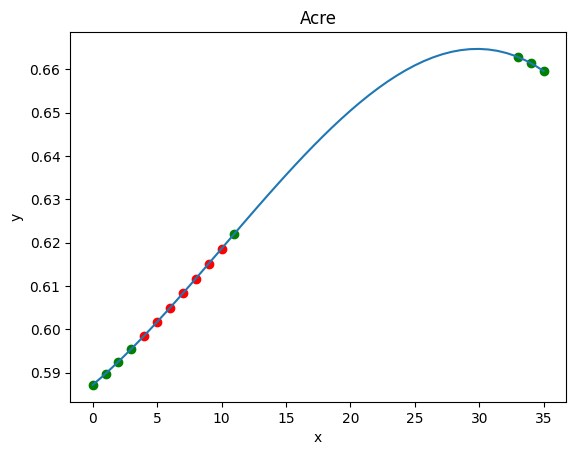

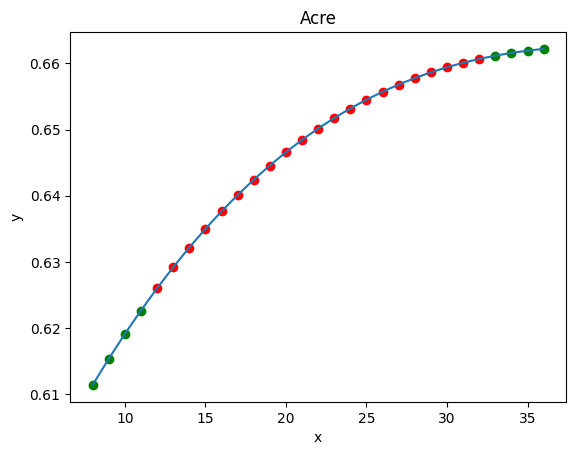

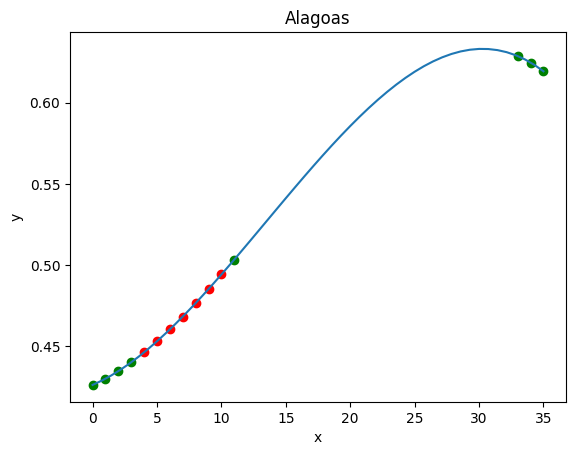

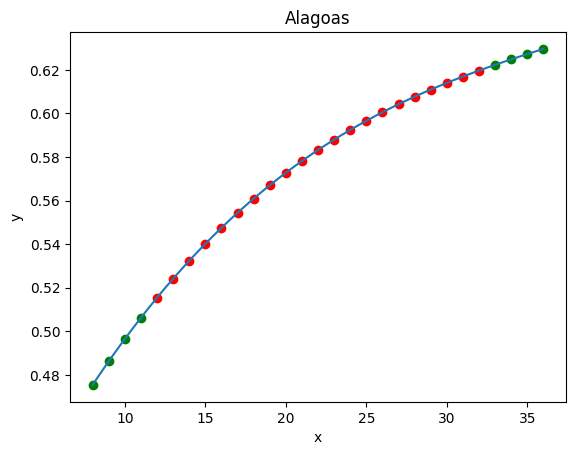

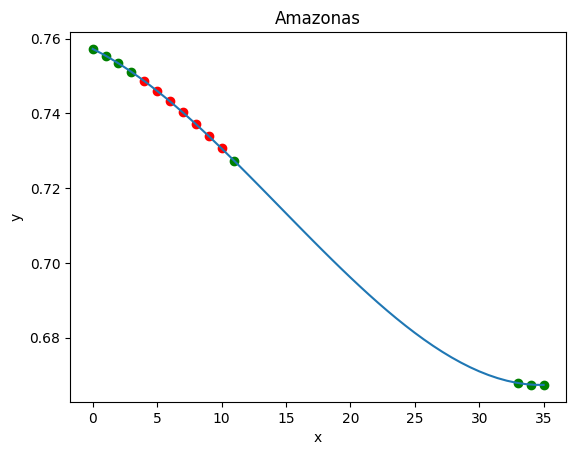

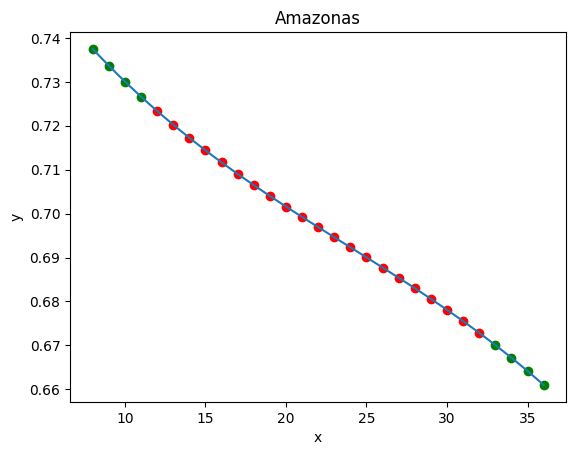

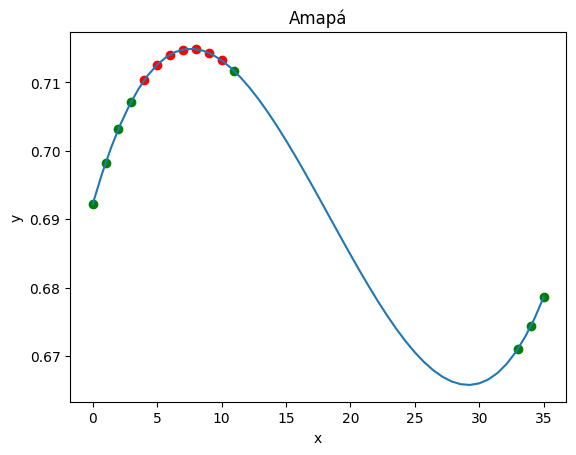

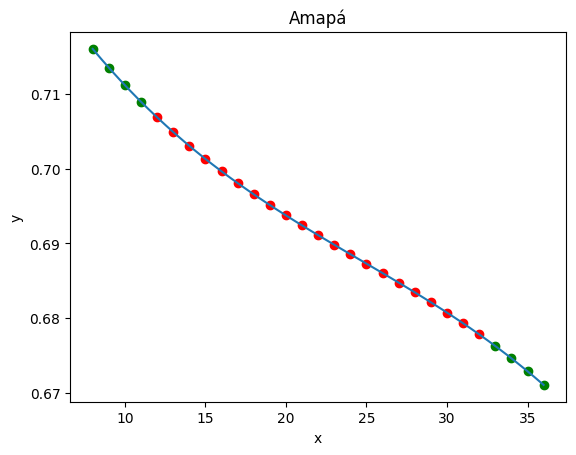

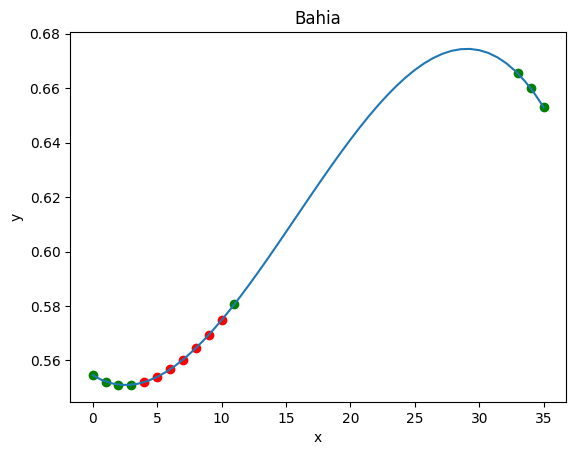

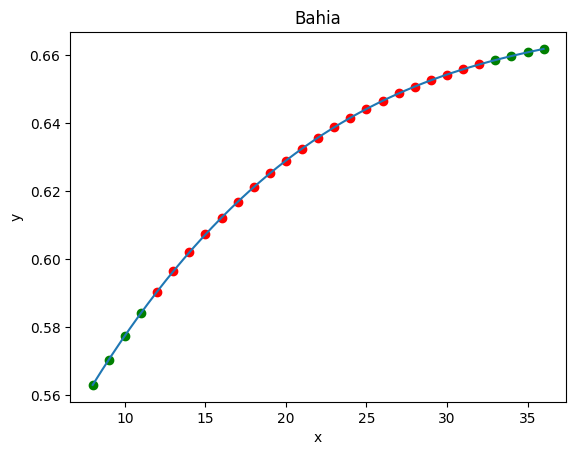

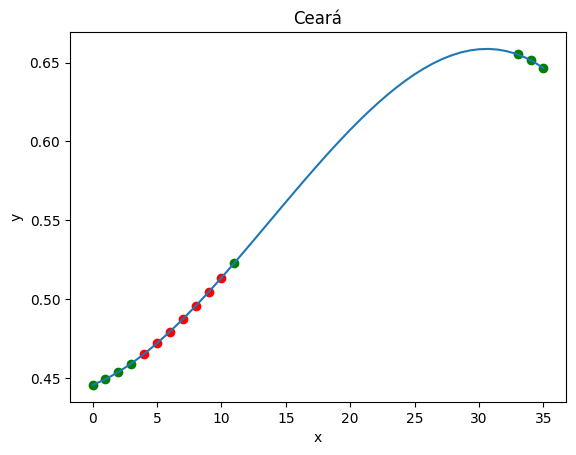

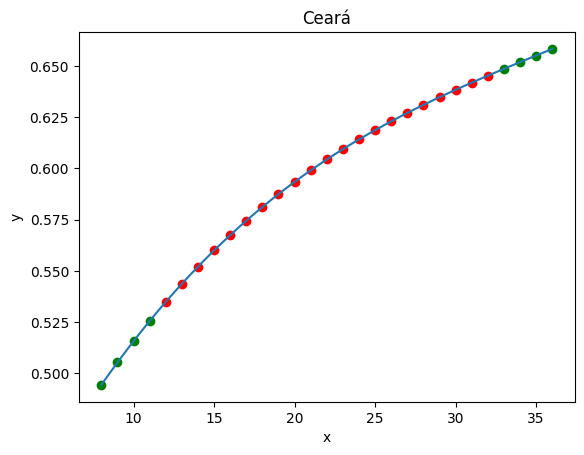

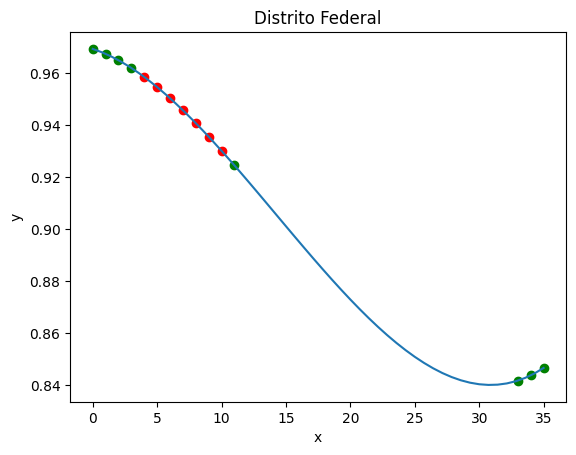

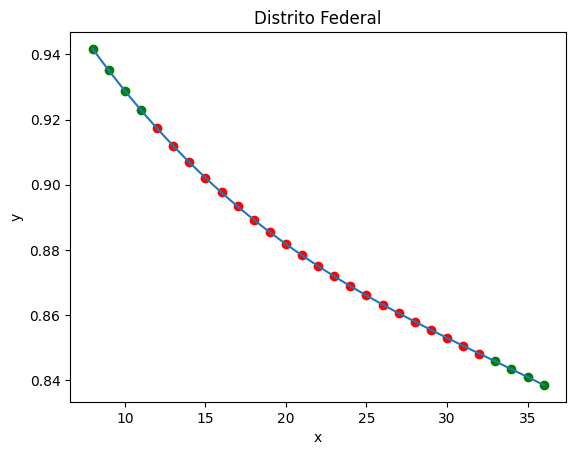

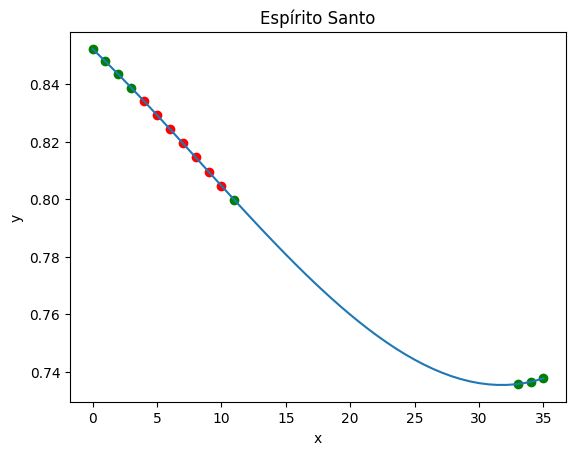

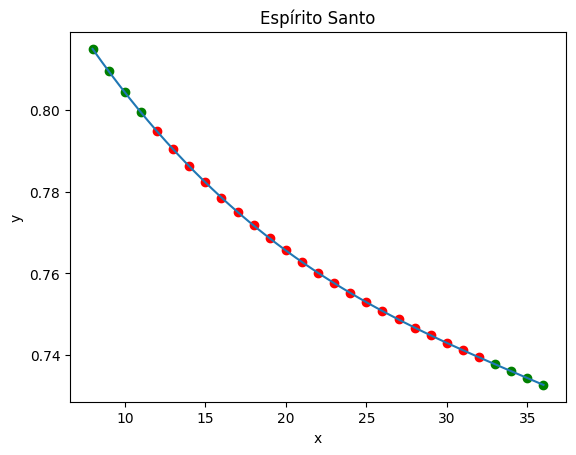

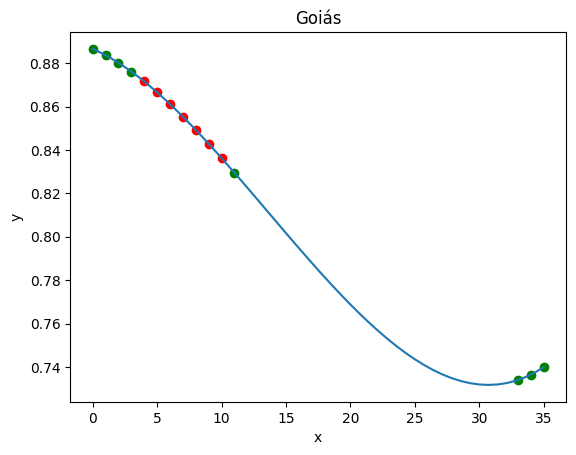

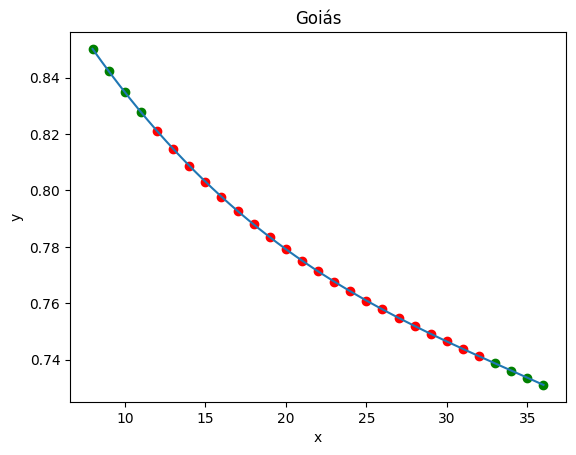

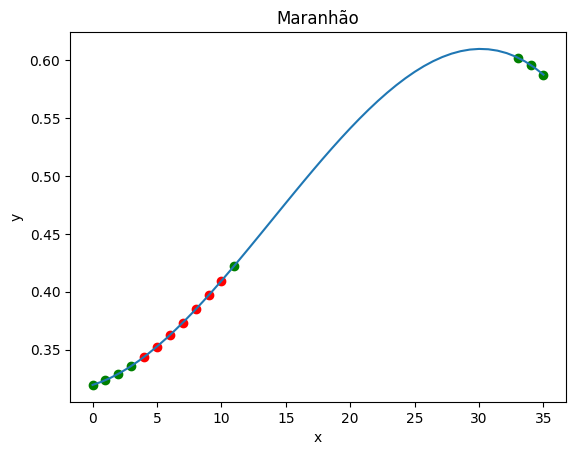

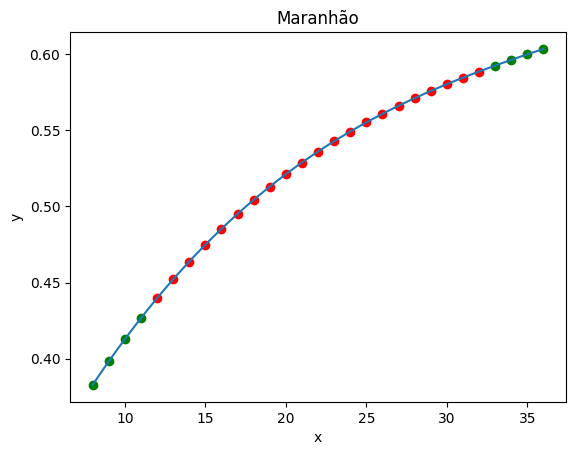

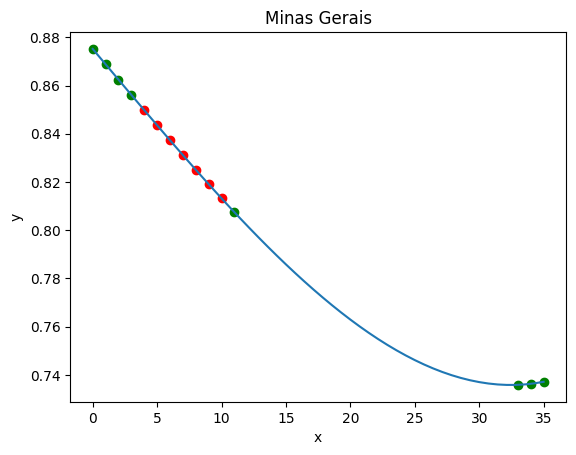

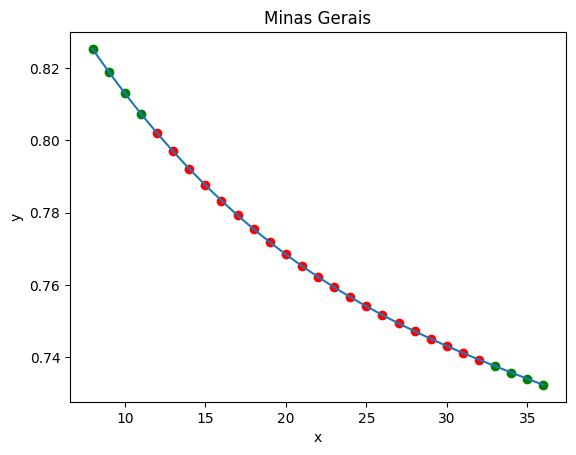

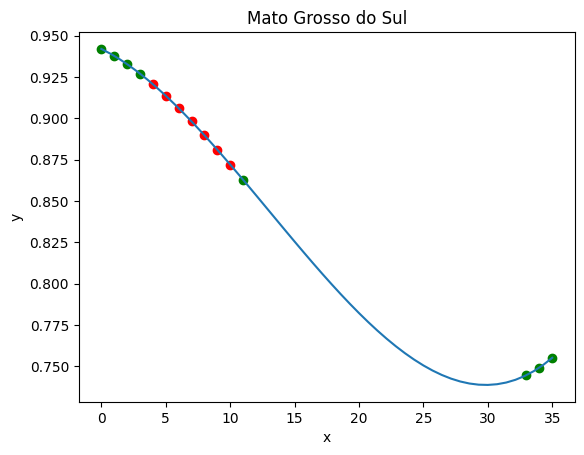

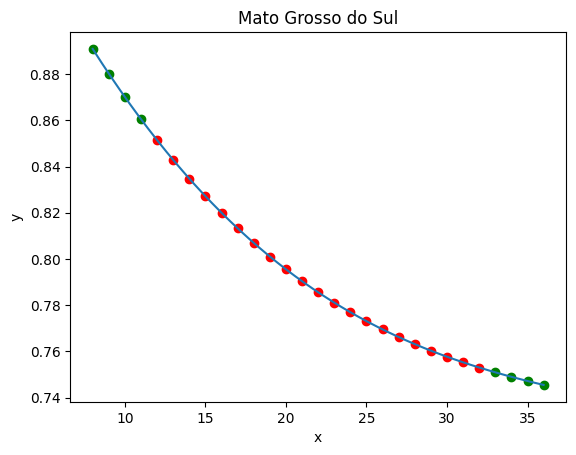

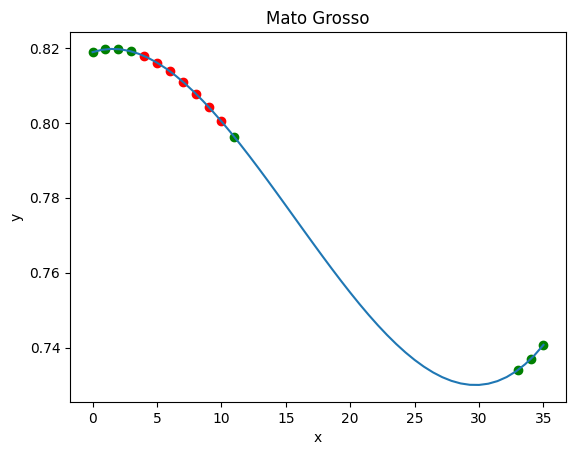

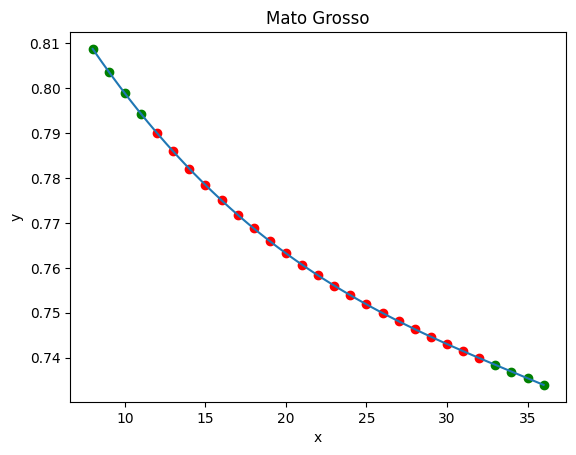

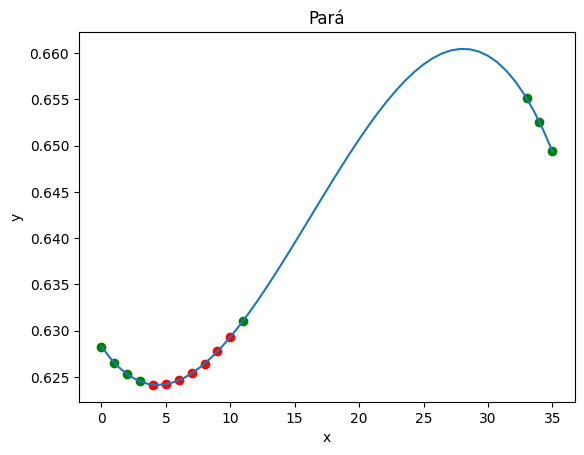

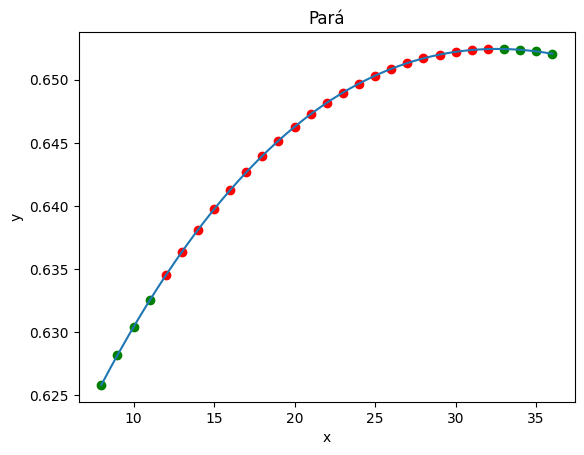

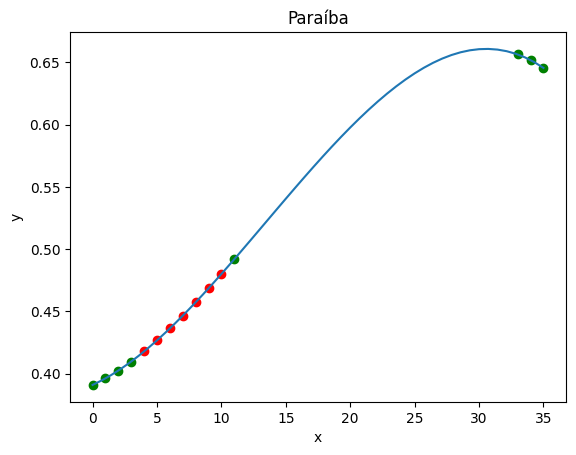

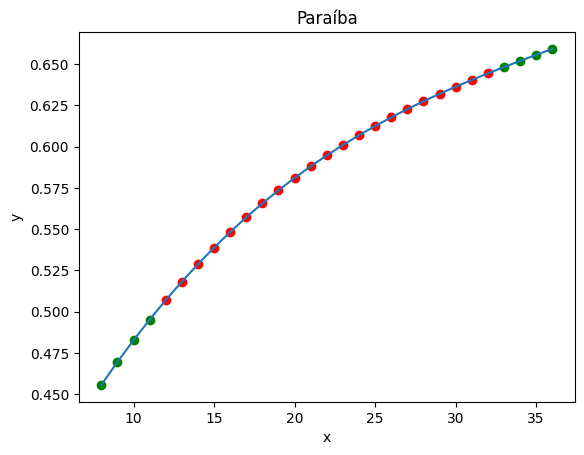

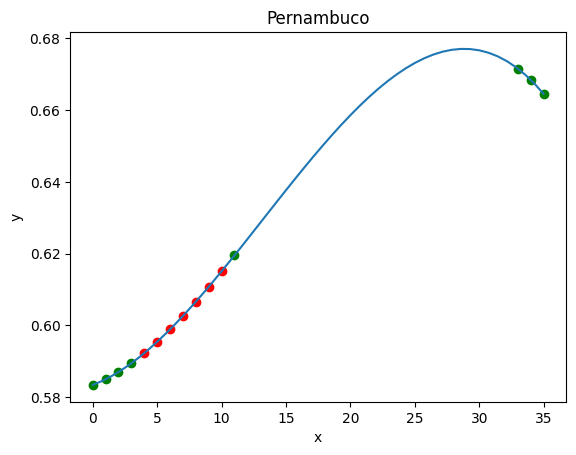

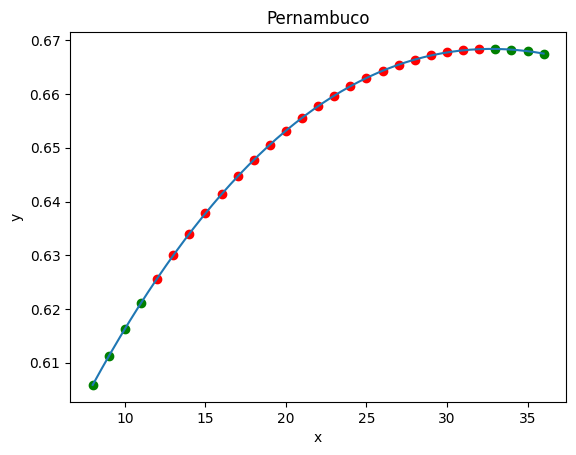

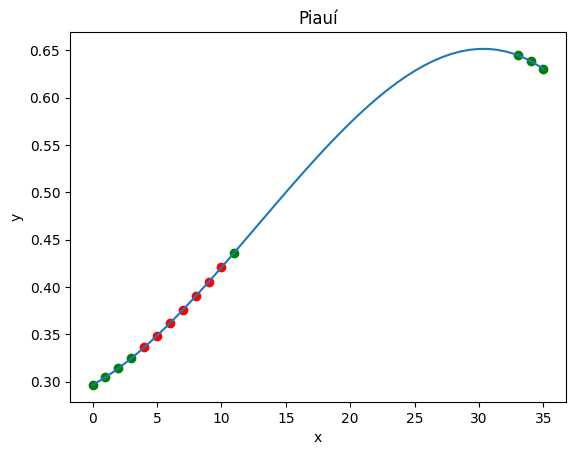

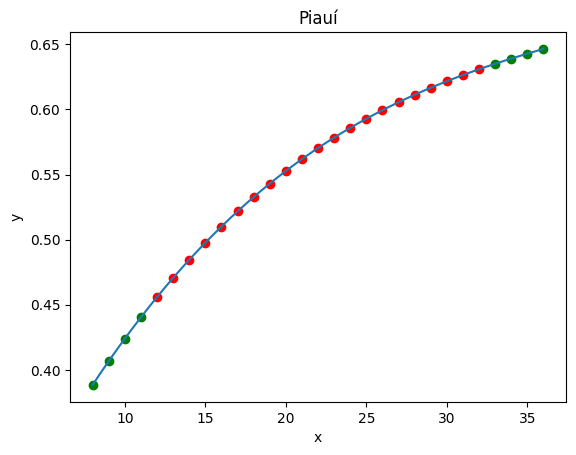

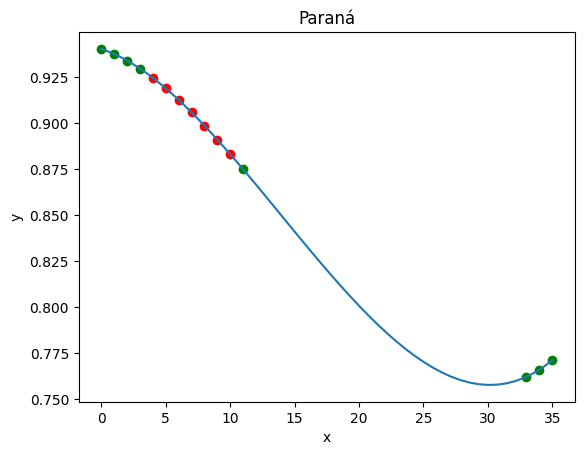

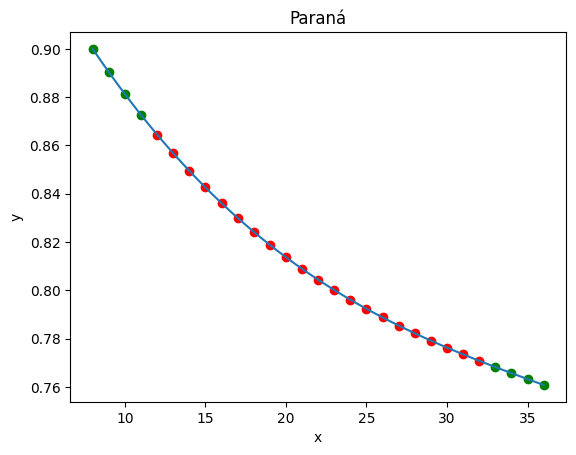

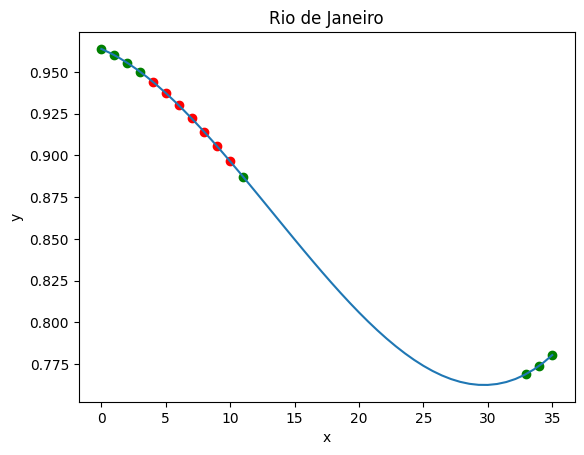

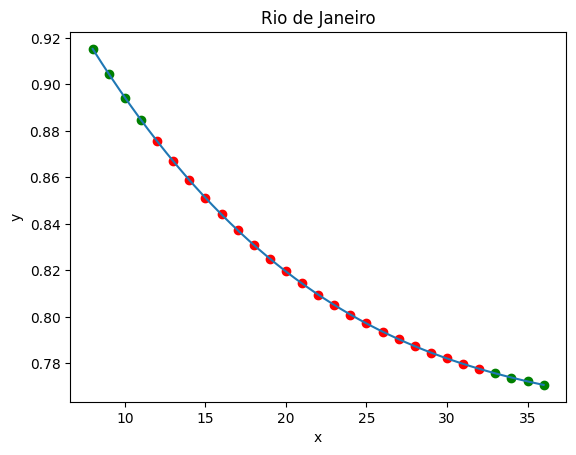

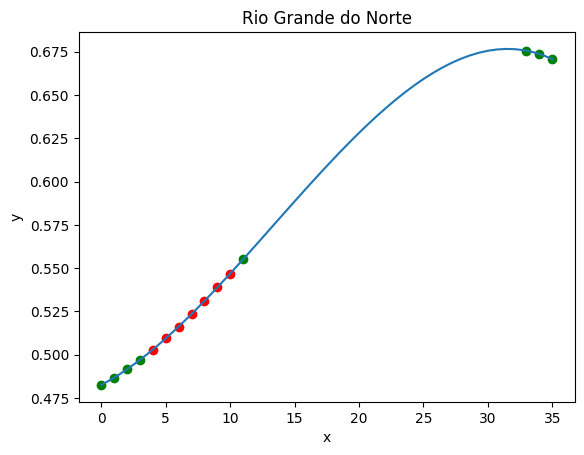

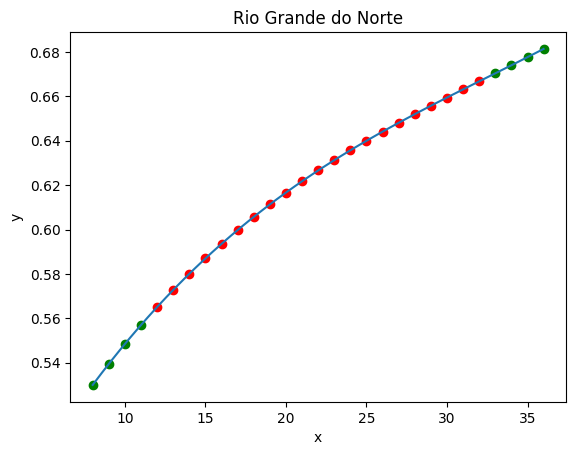

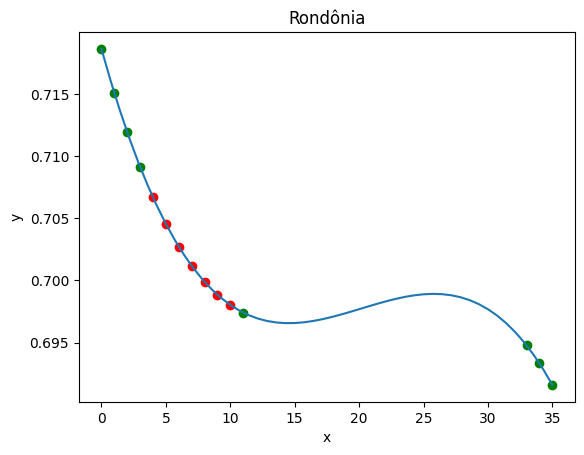

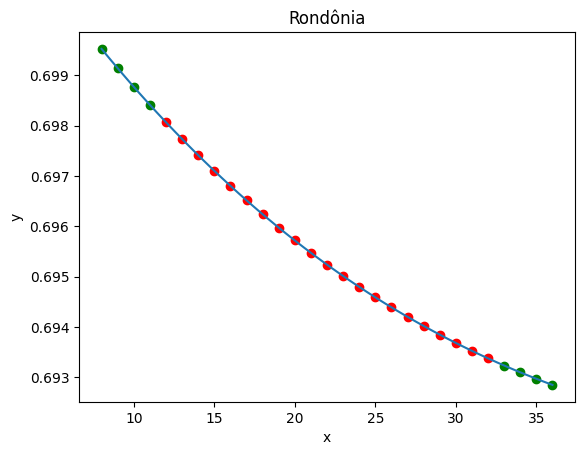

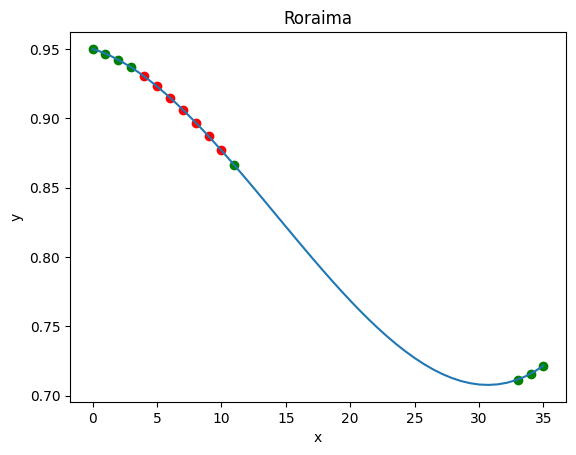

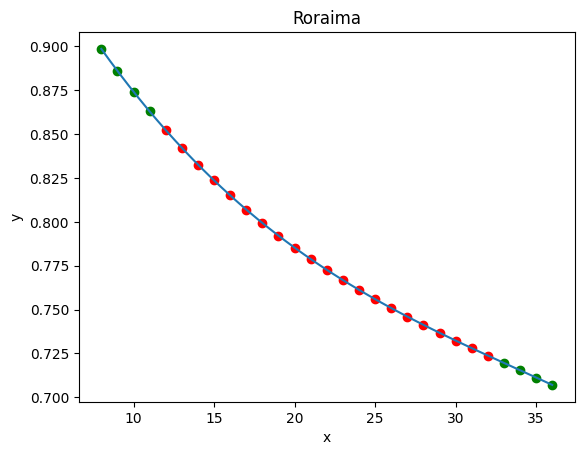

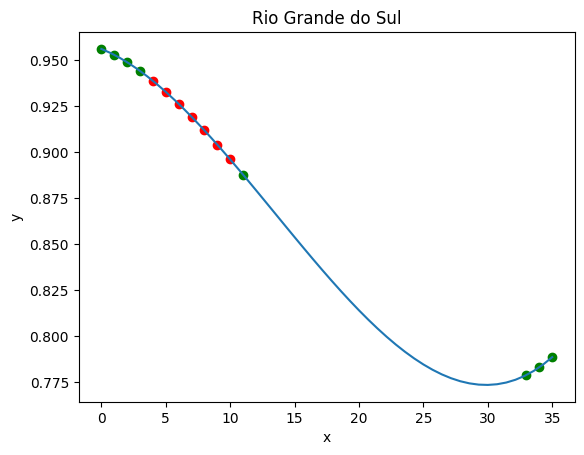

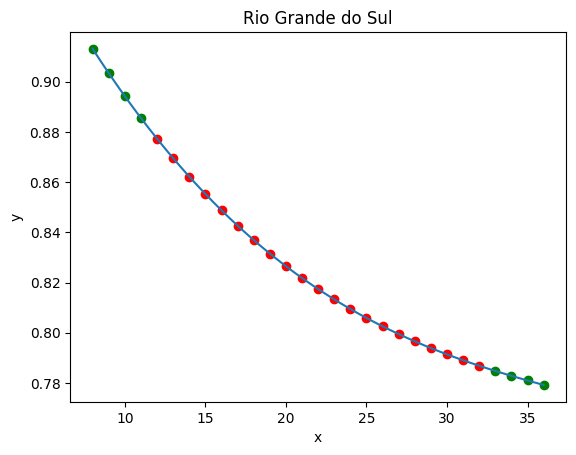

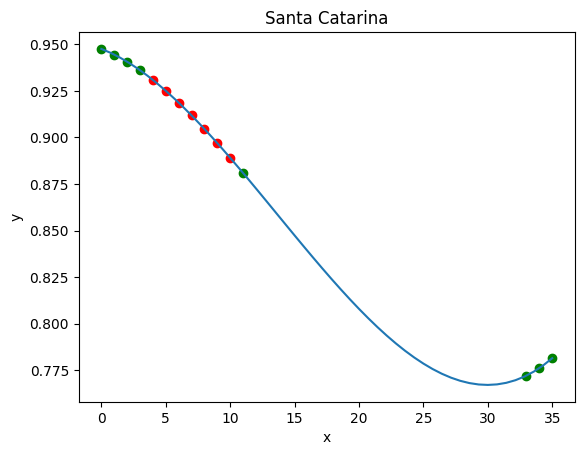

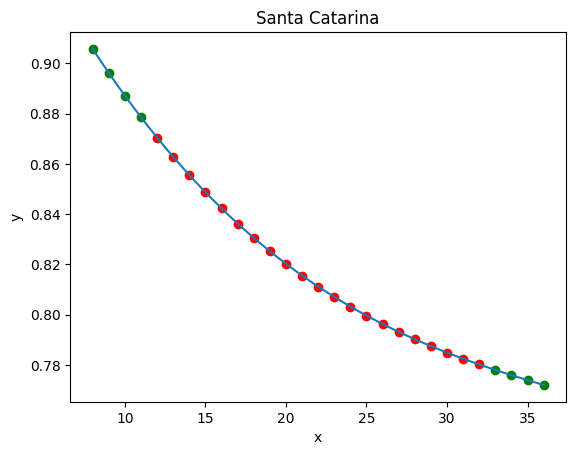

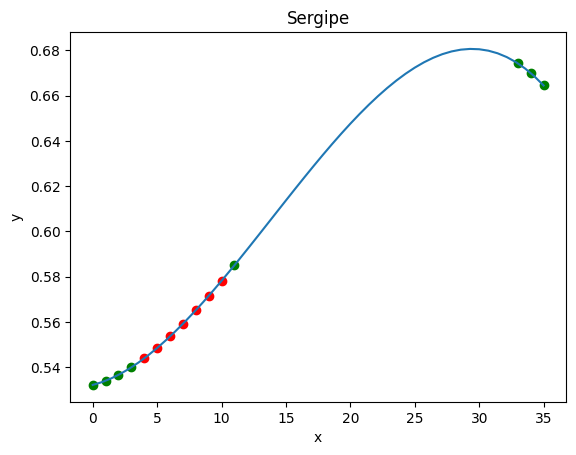

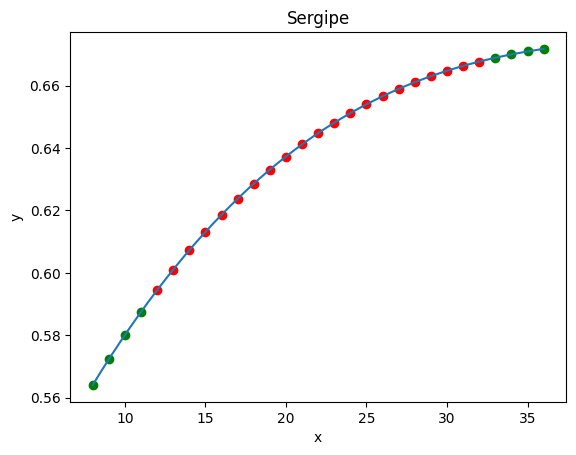

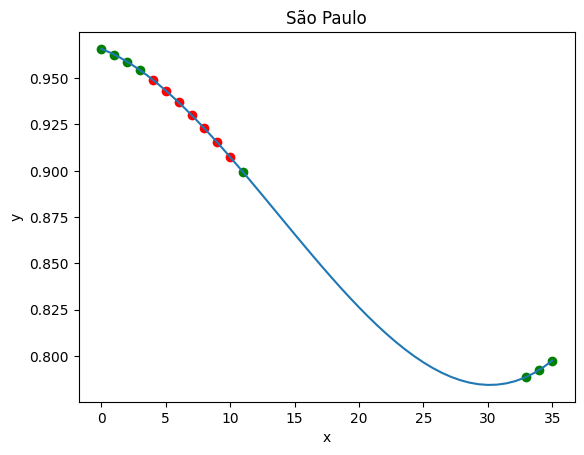

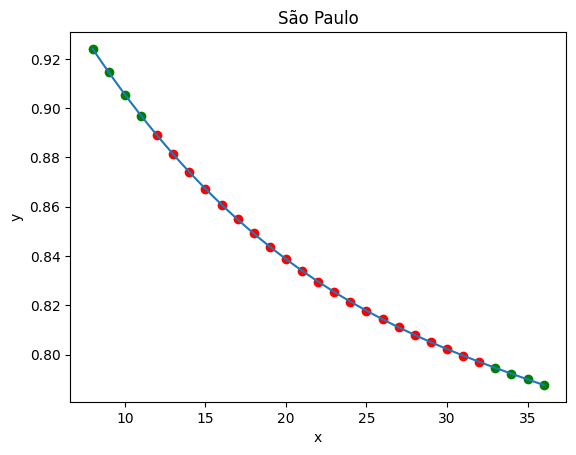

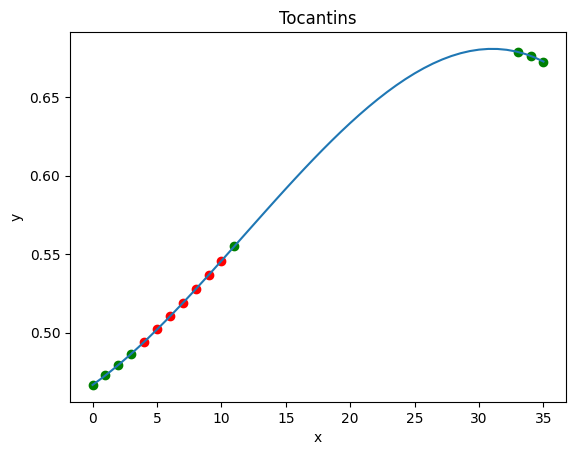

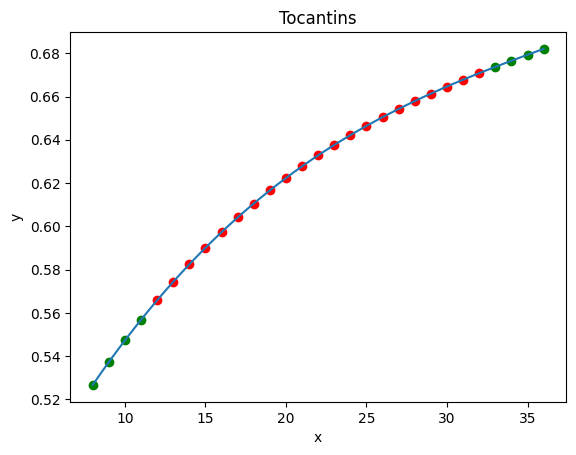

,Acre - IDH Renda,Alagoas - IDH Renda,Amazonas - IDH Renda,Amapá - IDH Renda,Bahia - IDH Renda,Ceará - IDH Renda,Distrito Federal - IDH Renda,Espírito Santo - IDH Renda,Goiás - IDH Renda,Maranhão - IDH Renda,...,Paraná - IDH Renda,Rio de Janeiro - IDH Renda,Rio Grande do Norte - IDH Renda,Rondônia - IDH Renda,Roraima - IDH Renda,Rio Grande do Sul - IDH Renda,Santa Catarina - IDH Renda,Sergipe - IDH Renda,São Paulo - IDH Renda,Tocantins - IDH Renda
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.588200,0.431545,0.756127,0.686618,0.561600,0.450545,0.966236,0.851673,0.883291,0.327509,...,0.935855,0.958836,0.486273,0.720727,0.943636,0.951764,0.943000,0.536891,0.961382,0.470091
1981,0.590240,0.431855,0.754953,0.696942,0.554120,0.450855,0.966484,0.847407,0.882549,0.326211,...,0.936225,0.958404,0.488127,0.715473,0.944564,0.951516,0.943000,0.535469,0.961258,0.474109
1982,0.592088,0.432135,0.753889,0.706294,0.547344,0.451135,0.966708,0.843543,0.881877,0.325035,...,0.936561,0.958012,0.489807,0.710713,0.945404,0.951292,0.943000,0.534181,0.961146,0.477749
1983,0.593706,0.432380,0.752957,0.714480,0.541413,0.451380,0.966904,0.840161,0.881289,0.324006,...,0.936856,0.957669,0.491278,0.706546,0.946139,0.951096,0.943000,0.533054,0.961048,0.480935
1984,0.598543,0.446387,0.748646,0.710305,0.552051,0.465171,0.958629,0.834046,0.871602,0.343768,...,0.924778,0.944094,0.503010,0.706684,0.930236,0.938891,0.930900,0.543929,0.949134,0.494049
1985,0.601711,0.453167,0.746000,0.712566,0.553960,0.471944,0.954730,0.829248,0.866586,0.352709,...,0.919084,0.937372,0.509429,0.704555,0.922969,0.932894,0.925072,0.548502,0.943318,0.501981
1986,0.604973,0.460518,0.743189,0.714038,0.556727,0.479320,0.950436,0.824386,0.861159,0.362594,...,0.912813,0.930068,0.516270,0.702727,0.914936,0.926359,0.918702,0.553609,0.936964,0.510250
1987,0.608312,0.468371,0.740229,0.714780,0.560273,0.487231,0.945792,0.819479,0.855369,0.373317,...,0.906032,0.922252,0.523483,0.701182,0.906219,0.919351,0.911854,0.559191,0.930135,0.518806
1988,0.611708,0.476661,0.737138,0.714852,0.564519,0.495607,0.940838,0.814544,0.849263,0.384775,...,0.898804,0.913995,0.531018,0.699898,0.896903,0.911932,0.904591,0.565188,0.922893,0.527598


In [10]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df.columns = df.columns + ' - IDH Renda'
df

In [11]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre - IDH Renda,Alagoas - IDH Renda,Amazonas - IDH Renda,Amapá - IDH Renda,Bahia - IDH Renda,Ceará - IDH Renda,Distrito Federal - IDH Renda,Espírito Santo - IDH Renda,Goiás - IDH Renda,Maranhão - IDH Renda,...,Paraná - IDH Renda,Rio de Janeiro - IDH Renda,Rio Grande do Norte - IDH Renda,Rondônia - IDH Renda,Roraima - IDH Renda,Rio Grande do Sul - IDH Renda,Santa Catarina - IDH Renda,Sergipe - IDH Renda,São Paulo - IDH Renda,Tocantins - IDH Renda
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.660516,0.623605,0.666397,0.674157,0.658428,0.650584,0.843857,0.737011,0.736954,0.593989,...,0.767235,0.776356,0.673657,0.693110,0.716277,0.784785,0.777652,0.668238,0.793855,0.675455
2015,0.663153,0.632170,0.659448,0.669988,0.663376,0.661305,0.836668,0.730914,0.728616,0.607501,...,0.758000,0.767785,0.683929,0.692762,0.703535,0.776477,0.769407,0.673638,0.784967,0.684629
2016,0.662167,0.631822,0.658216,0.668169,0.662683,0.661696,0.835729,0.730906,0.728399,0.607001,...,0.758363,0.768675,0.683650,0.693104,0.702129,0.776520,0.769444,0.673060,0.785237,0.684323
2017,0.662364,0.631351,0.658599,0.666912,0.662745,0.662214,0.835704,0.731261,0.728799,0.606273,...,0.758578,0.769373,0.683346,0.693749,0.701049,0.776931,0.770030,0.672156,0.785077,0.684807
2018,0.663033,0.631383,0.657381,0.665449,0.661631,0.661870,0.835132,0.731648,0.728236,0.605389,...,0.758540,0.770497,0.684377,0.693817,0.701418,0.777015,0.769851,0.672352,0.785447,0.684608
2019,0.661854,0.630873,0.657597,0.665399,0.661416,0.661495,0.835053,0.731343,0.727621,0.604697,...,0.757862,0.770179,0.684230,0.692346,0.699456,0.777199,0.769656,0.672021,0.784943,0.683390
2020,0.661296,0.630407,0.657561,0.665436,0.660362,0.660085,0.834512,0.729920,0.727495,0.603852,...,0.757303,0.769014,0.683432,0.691196,0.699770,0.776671,0.769079,0.671114,0.784392,0.682517
2021,0.660686,0.629080,0.657611,0.665657,0.658668,0.657911,0.835195,0.729640,0.727995,0.602293,...,0.757877,0.768924,0.682381,0.690032,0.701567,0.776914,0.769631,0.669669,0.784700,0.681745
2022,0.661203,0.628996,0.659122,0.667262,0.659638,0.657903,0.836486,0.730971,0.729267,0.602228,...,0.759138,0.769826,0.681506,0.691217,0.703528,0.777815,0.770598,0.670367,0.785946,0.681540


In [12]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_rend_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)

In [13]:
df_2008 = df[df.index >= 2008]
df_2008

,Acre - IDH Renda,Alagoas - IDH Renda,Amazonas - IDH Renda,Amapá - IDH Renda,Bahia - IDH Renda,Ceará - IDH Renda,Distrito Federal - IDH Renda,Espírito Santo - IDH Renda,Goiás - IDH Renda,Maranhão - IDH Renda,...,Paraná - IDH Renda,Rio de Janeiro - IDH Renda,Rio Grande do Norte - IDH Renda,Rondônia - IDH Renda,Roraima - IDH Renda,Rio Grande do Sul - IDH Renda,Santa Catarina - IDH Renda,Sergipe - IDH Renda,São Paulo - IDH Renda,Tocantins - IDH Renda
Ano,,,,,,,,,,,,,,,,,,,,,
2008,0.657765,0.607691,0.683013,0.683446,0.650668,0.630941,0.858039,0.746748,0.751937,0.571090,...,0.782206,0.787362,0.651916,0.694019,0.741317,0.796566,0.790219,0.661089,0.807995,0.657894
2009,0.658635,0.610950,0.680583,0.682114,0.652511,0.634697,0.855523,0.744843,0.749149,0.575808,...,0.779167,0.784607,0.655700,0.693847,0.736778,0.793878,0.787470,0.663021,0.805067,0.661339
2010,0.659404,0.614023,0.678086,0.680739,0.654198,0.638313,0.853062,0.743004,0.746443,0.580279,...,0.776268,0.782076,0.659411,0.693682,0.732364,0.791370,0.784890,0.664760,0.802285,0.664624
2011,0.660077,0.616930,0.675510,0.679313,0.655741,0.641811,0.850640,0.741218,0.743804,0.584528,...,0.773492,0.779754,0.663071,0.693525,0.728051,0.789026,0.782462,0.666316,0.799634,0.667767
2012,0.660660,0.619689,0.672842,0.677825,0.657154,0.645211,0.848244,0.739477,0.741216,0.588585,...,0.770820,0.777623,0.666698,0.693376,0.723813,0.786830,0.780170,0.667702,0.797095,0.670786
2012,0.661919,0.624249,0.668853,0.675264,0.659620,0.650770,0.844316,0.736258,0.736635,0.595529,...,0.766005,0.773416,0.672193,0.693088,0.716810,0.782580,0.775917,0.670256,0.792457,0.675665
2013,0.661246,0.624020,0.667675,0.675453,0.659088,0.651001,0.844176,0.736780,0.737188,0.594989,...,0.766756,0.774867,0.673375,0.693179,0.716794,0.783878,0.776910,0.669528,0.793328,0.675804
2014,0.660516,0.623605,0.666397,0.674157,0.658428,0.650584,0.843857,0.737011,0.736954,0.593989,...,0.767235,0.776356,0.673657,0.693110,0.716277,0.784785,0.777652,0.668238,0.793855,0.675455
2015,0.663153,0.632170,0.659448,0.669988,0.663376,0.661305,0.836668,0.730914,0.728616,0.607501,...,0.758000,0.767785,0.683929,0.692762,0.703535,0.776477,0.769407,0.673638,0.784967,0.684629


In [14]:
for column in df_2008.columns:
    state = column
    file_name = f"2008_01_idh_rend_{state}.csv"
    column_df = df_2008[[column]]
    column_df.to_csv(file_name, index=True)

In [15]:
df_2003 = df[df.index >= 2003]
df_2003

,Acre - IDH Renda,Alagoas - IDH Renda,Amazonas - IDH Renda,Amapá - IDH Renda,Bahia - IDH Renda,Ceará - IDH Renda,Distrito Federal - IDH Renda,Espírito Santo - IDH Renda,Goiás - IDH Renda,Maranhão - IDH Renda,...,Paraná - IDH Renda,Rio de Janeiro - IDH Renda,Rio Grande do Norte - IDH Renda,Rondônia - IDH Renda,Roraima - IDH Renda,Rio Grande do Sul - IDH Renda,Santa Catarina - IDH Renda,Sergipe - IDH Renda,São Paulo - IDH Renda,Tocantins - IDH Renda
Ano,,,,,,,,,,,,,,,,,,,,,
2003,0.651726,0.587982,0.694618,0.689809,0.638715,0.609343,0.871928,0.757615,0.767692,0.542831,...,0.800130,0.805095,0.631207,0.695011,0.766811,0.813273,0.807065,0.648121,0.825444,0.637611
2004,0.653176,0.592441,0.692327,0.688544,0.641511,0.614109,0.868928,0.755227,0.764245,0.549196,...,0.796122,0.800966,0.635654,0.694794,0.761253,0.809442,0.803228,0.651194,0.821522,0.642137
2005,0.654500,0.596623,0.690034,0.687285,0.644092,0.618630,0.866053,0.752956,0.760962,0.555177,...,0.792343,0.797145,0.639929,0.694587,0.755950,0.805872,0.799641,0.654015,0.817833,0.646410
2006,0.655703,0.600546,0.687725,0.686022,0.646471,0.622929,0.863290,0.750793,0.757828,0.560802,...,0.788776,0.793615,0.644050,0.694389,0.750877,0.802546,0.796288,0.656597,0.814361,0.650448
2007,0.656789,0.604229,0.685389,0.684746,0.648659,0.627026,0.860623,0.748727,0.754825,0.566097,...,0.785403,0.790359,0.648039,0.694200,0.746008,0.799450,0.793153,0.658952,0.811087,0.654270
2008,0.657765,0.607691,0.683013,0.683446,0.650668,0.630941,0.858039,0.746748,0.751937,0.571090,...,0.782206,0.787362,0.651916,0.694019,0.741317,0.796566,0.790219,0.661089,0.807995,0.657894
2009,0.658635,0.610950,0.680583,0.682114,0.652511,0.634697,0.855523,0.744843,0.749149,0.575808,...,0.779167,0.784607,0.655700,0.693847,0.736778,0.793878,0.787470,0.663021,0.805067,0.661339
2010,0.659404,0.614023,0.678086,0.680739,0.654198,0.638313,0.853062,0.743004,0.746443,0.580279,...,0.776268,0.782076,0.659411,0.693682,0.732364,0.791370,0.784890,0.664760,0.802285,0.664624
2011,0.660077,0.616930,0.675510,0.679313,0.655741,0.641811,0.850640,0.741218,0.743804,0.584528,...,0.773492,0.779754,0.663071,0.693525,0.728051,0.789026,0.782462,0.666316,0.799634,0.667767


In [16]:
for column in df_2003.columns:
    state = column
    file_name = f"2003_01_idh_rend_{state}.csv"
    column_df = df_2003[[column]]
    column_df.to_csv(file_name, index=True)

In [17]:
def dataframe_expanded_interpolation(df):
    expanded_df = pd.DataFrame(columns=df.columns)
    for i, (_, row) in enumerate(df.iterrows()):
        if i > 0:
            expanded_df = pd.concat([expanded_df, pd.DataFrame(columns=df.columns, index=[None] * 11)])
        expanded_df = pd.concat([expanded_df, pd.DataFrame(row).T])
    expanded_df = expanded_df.reset_index(drop=True)
    expanded_df.interpolate(method='linear', axis=0, inplace=True)

    return expanded_df

def add_ano_column(df):
    new_df = df.copy()
    ano_start = 2002
    for i in range(len(new_df)):
        if i % 12 == 0:
            ano_start += 1
        new_df.at[i, 'Ano'] =  str(ano_start)

    return new_df

def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [18]:
pd.set_option('display.max_rows', None)
df_mo_2003 = dataframe_expanded_interpolation(df_2003)
df_mo_2003 = add_ano_column(df_mo_2003)
df_mo_2003 = df_mo_2003.set_index('Ano', inplace=False)
df_mo_2003 = add_month(df_mo_2003)
df_mo_2003

,Acre - IDH Renda,Alagoas - IDH Renda,Amazonas - IDH Renda,Amapá - IDH Renda,Bahia - IDH Renda,Ceará - IDH Renda,Distrito Federal - IDH Renda,Espírito Santo - IDH Renda,Goiás - IDH Renda,Maranhão - IDH Renda,...,Paraná - IDH Renda,Rio de Janeiro - IDH Renda,Rio Grande do Norte - IDH Renda,Rondônia - IDH Renda,Roraima - IDH Renda,Rio Grande do Sul - IDH Renda,Santa Catarina - IDH Renda,Sergipe - IDH Renda,São Paulo - IDH Renda,Tocantins - IDH Renda
2003-1,0.651726,0.587982,0.694618,0.689809,0.638715,0.609343,0.871928,0.757615,0.767692,0.542831,...,0.800130,0.805095,0.631207,0.695011,0.766811,0.813273,0.807065,0.648121,0.825444,0.637611
2003-2,0.651847,0.588354,0.694427,0.689704,0.638948,0.609740,0.871678,0.757416,0.767405,0.543362,...,0.799796,0.804751,0.631578,0.694993,0.766348,0.812953,0.806745,0.648377,0.825117,0.637988
2003-3,0.651968,0.588725,0.694236,0.689598,0.639181,0.610137,0.871428,0.757217,0.767117,0.543892,...,0.799462,0.804407,0.631948,0.694975,0.765885,0.812634,0.806425,0.648633,0.824790,0.638365
2003-4,0.652088,0.589097,0.694045,0.689493,0.639414,0.610534,0.871178,0.757018,0.766830,0.544422,...,0.799128,0.804063,0.632319,0.694957,0.765422,0.812315,0.806105,0.648889,0.824463,0.638742
2003-5,0.652209,0.589469,0.693854,0.689387,0.639647,0.610931,0.870928,0.756819,0.766543,0.544953,...,0.798794,0.803719,0.632689,0.694939,0.764958,0.811996,0.805786,0.649145,0.824137,0.639120
2003-6,0.652330,0.589840,0.693663,0.689282,0.639880,0.611329,0.870678,0.756620,0.766256,0.545483,...,0.798460,0.803375,0.633060,0.694921,0.764495,0.811676,0.805466,0.649401,0.823810,0.639497
2003-7,0.652451,0.590212,0.693473,0.689177,0.640113,0.611726,0.870428,0.756421,0.765968,0.546014,...,0.798126,0.803031,0.633431,0.694903,0.764032,0.811357,0.805146,0.649657,0.823483,0.639874
2003-8,0.652572,0.590583,0.693282,0.689071,0.640346,0.612123,0.870178,0.756222,0.765681,0.546544,...,0.797792,0.802687,0.633801,0.694885,0.763569,0.811038,0.804826,0.649913,0.823156,0.640251
2003-9,0.652693,0.590955,0.693091,0.688966,0.640579,0.612520,0.869928,0.756023,0.765394,0.547074,...,0.797458,0.802343,0.634172,0.694867,0.763106,0.810719,0.804507,0.650169,0.822829,0.640628
2003-10,0.652813,0.591326,0.692900,0.688860,0.640812,0.612917,0.869678,0.755824,0.765107,0.547605,...,0.797124,0.801998,0.634543,0.694849,0.762643,0.810399,0.804187,0.650425,0.822502,0.641006


In [19]:
for column in df_mo_2003.columns:
    state = column
    file_name = f"2003_mo_idh_renda_{state}.csv"
    column_df = df_mo_2003[[column]]
    column_df.to_csv(file_name, index=True)